In [1]:
import json
import requests
from bs4 import BeautifulSoup
import time
import csv
import pandas as pd
import matplotlib.pyplot as plt
import re

%matplotlib inline

In [2]:
team_handles_dict = {'Toronto Raptors': 'TOR',
                     'Boston Celtics': 'BOS',
                     'Philadelphia 76ers': 'PHI',
                     'Cleveland Cavaliers': 'CLE',
                     'Indiana Pacers': 'IND',
                     'Miami Heat': 'MIA',
                     'Milwaukee Bucks': 'MIL',
                     'Washington Wizards': 'WAS',
                     'Detroit Pistons': 'DET',
                     #'Charlotte Hornets': 'CHO',
                     #'Charlotte Bobcats': 'CHA',
                     'New York Knicks': 'NYK',
                     'Brooklyn Nets': 'BRK',
                     'Chicago Bulls': 'CHI',
                     'Orlando Magic': 'ORL',
                     'Atlanta Hawks': 'ATL',
                     'Houston Rockets': 'HOU',
                     'Golden State Warriors': 'GSW',
                     'Portland Trail Blazers': 'POR',
                     'Oklahoma City Thunder': 'OKC',
                     'Utah Jazz': 'UTA',
                     'New Orleans Pelicans': 'NOP',
                     'San Antonio Spurs': 'SAS',
                     'Minnesota Timberwolves': 'MIN',
                     'Denver Nuggets': 'DEN',
                     'L.A. Clippers': 'LAC',
                     'L.A. Lakers': 'LAL',
                     'Sacramento Kings': 'SAC',
                     'Dallas Mavericks': 'DAL',
                     'Memphis Grizzlies': 'MEM',
                     'Phoenix Suns': 'PHO'}

In [3]:
def dataframe_loader(years_games):
    years_stats = []
    for game in years_games:
        with open(f'{game}') as g:
            years_stats.append(json.load(g))
    all_games_year = [team for game_list in years_stats for game in game_list for team in game]
    df_year = pd.DataFrame(all_games_year, columns=['gid', 'team_slug', 'away_home', 'mp', 'fg', 'fga',
                                                    'fg%', '3p', '3pa', '3p%', 'ft', 'fta', 'ft%', 'orb',
                                                    'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts'])
    return df_year

In [4]:
gl_2014 = !ls ../*_2014.json
gl_2015 = !ls ../*_2015.json
gl_2016 = !ls ../*_2016.json
gl_2017 = !ls ../*_2017.json
gl_2018 = !ls ../*_2018.json

df_2014 = dataframe_loader(gl_2014)
df_2015 = dataframe_loader(gl_2015)
df_2016 = dataframe_loader(gl_2016)
df_2017 = dataframe_loader(gl_2017)
df_2018 = dataframe_loader(gl_2018)

In [5]:
df_all = df_2014.append([df_2015, df_2016, df_2017, df_2018], ignore_index=True)

In [6]:
df_all['date'] = df_all['gid'].map(lambda x: x[:8])

In [7]:
with open('../all_gambling_lines.json') as g:
     all_lines = json.load(g)

In [8]:
df_lines = pd.DataFrame(data=all_lines[0])
for day_line in all_lines[1:]:
    df_lines = df_lines.append(day_line, ignore_index=True).copy()

Writing this cell to make corrections to the lines for data points where I have to manually impute the line because the line was missing from the website I scraped

In [9]:
df_lines[~df_lines[2].str.contains(' ')]

,0,1,2
384,20140116,Brooklyn,
385,20140116,Atlanta,
2466,20141101,Dallas,
2467,20141101,New Orleans,
5677,20151106,Indiana,


In [10]:
df_lines.loc[384, 2] = '-1 -105'
df_lines.loc[385, 2] = '194.5 -105'
df_lines.loc[2466, 2] = '203.5 -105'
df_lines.loc[2467, 2] = '-1 -105'
df_lines.loc[5677, 2] = '0 -105'

Writing this cell to append missing lines to my Dataframe

In [11]:
missing_lines = pd.DataFrame([['20150306', 'Miami', '+6 -110'], 
                             ['20150306', 'Washington','193 -110']])
                             #columns=['date', 'team', 'full_line'])

In [12]:
df_lines = df_lines.append(missing_lines, ignore_index=True)

In [13]:
df_lines.rename({0:'date', 1:'team', 2:'full_line'}, axis=1, inplace=True)

In [14]:
df_lines['team_slug'] = df_lines['team']

In [15]:
for i, team in enumerate(df_lines['team']):
    if team == "Charlotte":
        if int(df_lines['date'][i]) < 20141001:
            df_lines['team_slug'][i] = 'CHA'
        else:
            df_lines['team_slug'][i] = 'CHO'
    else:
        for key in team_handles_dict:     
            if team in key:
                df_lines['team_slug'][i] = team_handles_dict[key]
            

In [16]:
df_lines['gid'] = df_lines['date'] + '0' + df_lines['team_slug']

In [17]:
for i, entry in enumerate(df_lines['gid']):
    if i % 2 == 0:
        df_lines['gid'][i] = df_lines['gid'][i+1]

In [18]:
df_all.head()

,gid,team_slug,away_home,mp,fg,fga,fg%,3p,3pa,3p%,...,orb,drb,trb,ast,stl,blk,tov,pf,pts,date
0,201311010ATL,TOR,away,240,40,88,.455,7,23,.304,...,10,32,42,15,5,6,12,25,95,20131101
1,201311010ATL,ATL,home,240,36,77,.468,10,23,.435,...,7,30,37,24,7,3,13,12,102,20131101
2,201311090ATL,ORL,away,240,38,82,.463,8,17,.471,...,9,27,36,22,9,2,17,24,94,20131109
3,201311090ATL,ATL,home,240,43,90,.478,6,19,.316,...,7,32,39,36,9,6,12,15,104,20131109
4,201311130ATL,NYK,away,240,37,88,.420,12,34,.353,...,8,29,37,24,11,3,3,19,95,20131113


In [19]:
df = pd.merge(df_all, df_lines, how='inner', on=['gid', 'team_slug'])

In [20]:
df.drop(['date_x', 'team', 'mp'], axis=1, inplace=True)

In [21]:
df.head()

,gid,team_slug,away_home,fg,fga,fg%,3p,3pa,3p%,ft,...,drb,trb,ast,stl,blk,tov,pf,pts,date_y,full_line
0,201311010ATL,TOR,away,40,88,.455,7,23,.304,8,...,32,42,15,5,6,12,25,95,20131101,195 -113
1,201311010ATL,ATL,home,36,77,.468,10,23,.435,20,...,30,37,24,7,3,13,12,102,20131101,-3½ -104
2,201311090ATL,ORL,away,38,82,.463,8,17,.471,10,...,27,36,22,9,2,17,24,94,20131109,199 -108
3,201311090ATL,ATL,home,43,90,.478,6,19,.316,12,...,32,39,36,9,6,12,15,104,20131109,-6½ -109
4,201311130ATL,NYK,away,37,88,.420,12,34,.353,9,...,29,37,24,11,3,3,19,95,20131113,201½ -105


In [22]:
df[~df['full_line'].str.contains(' ')]

,gid,team_slug,away_home,fg,fga,fg%,3p,3pa,3p%,ft,...,drb,trb,ast,stl,blk,tov,pf,pts,date_y,full_line


In [23]:
df['betting_line'] = df['full_line'].map(lambda x: str.split(x)[0])
df['bet_terms'] = df['full_line'].map(lambda x: str.split(x)[1])

In [24]:
df.head()

,gid,team_slug,away_home,fg,fga,fg%,3p,3pa,3p%,ft,...,ast,stl,blk,tov,pf,pts,date_y,full_line,betting_line,bet_terms
0,201311010ATL,TOR,away,40,88,.455,7,23,.304,8,...,15,5,6,12,25,95,20131101,195 -113,195,-113
1,201311010ATL,ATL,home,36,77,.468,10,23,.435,20,...,24,7,3,13,12,102,20131101,-3½ -104,-3½,-104
2,201311090ATL,ORL,away,38,82,.463,8,17,.471,10,...,22,9,2,17,24,94,20131109,199 -108,199,-108
3,201311090ATL,ATL,home,43,90,.478,6,19,.316,12,...,36,9,6,12,15,104,20131109,-6½ -109,-6½,-109
4,201311130ATL,NYK,away,37,88,.420,12,34,.353,9,...,24,11,3,3,19,95,20131113,201½ -105,201½,-105


In [25]:
doubled_df = df.merge(df, on='gid', right_index=True,  suffixes=['_home', '_away'])

In [26]:
doubled_df

,gid,team_slug_home,away_home_home,fg_home,fga_home,fg%_home,3p_home,3pa_home,3p%_home,ft_home,...,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,date_y_away,full_line_away,betting_line_away,bet_terms_away
0,201311010ATL,TOR,away,40,88,.455,7,23,.304,8,...,15,5,6,12,25,95,20131101,195 -113,195,-113
0,201311010ATL,TOR,away,40,88,.455,7,23,.304,8,...,24,7,3,13,12,102,20131101,-3½ -104,-3½,-104
1,201311010ATL,ATL,home,36,77,.468,10,23,.435,20,...,15,5,6,12,25,95,20131101,195 -113,195,-113
1,201311010ATL,ATL,home,36,77,.468,10,23,.435,20,...,24,7,3,13,12,102,20131101,-3½ -104,-3½,-104
2,201311090ATL,ORL,away,38,82,.463,8,17,.471,10,...,22,9,2,17,24,94,20131109,199 -108,199,-108
2,201311090ATL,ORL,away,38,82,.463,8,17,.471,10,...,36,9,6,12,15,104,20131109,-6½ -109,-6½,-109
3,201311090ATL,ATL,home,43,90,.478,6,19,.316,12,...,22,9,2,17,24,94,20131109,199 -108,199,-108
3,201311090ATL,ATL,home,43,90,.478,6,19,.316,12,...,36,9,6,12,15,104,20131109,-6½ -109,-6½,-109
4,201311130ATL,NYK,away,37,88,.420,12,34,.353,9,...,24,11,3,3,19,95,20131113,201½ -105,201½,-105
4,201311130ATL,NYK,away,37,88,.420,12,34,.353,9,...,22,1,6,15,15,91,20131113,-4½ -103,-4½,-103


In [27]:
merged_df = doubled_df[doubled_df['team_slug_home'] != doubled_df['team_slug_away']].copy()

In [28]:
merged_df

,gid,team_slug_home,away_home_home,fg_home,fga_home,fg%_home,3p_home,3pa_home,3p%_home,ft_home,...,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,date_y_away,full_line_away,betting_line_away,bet_terms_away
0,201311010ATL,TOR,away,40,88,.455,7,23,.304,8,...,24,7,3,13,12,102,20131101,-3½ -104,-3½,-104
1,201311010ATL,ATL,home,36,77,.468,10,23,.435,20,...,15,5,6,12,25,95,20131101,195 -113,195,-113
2,201311090ATL,ORL,away,38,82,.463,8,17,.471,10,...,36,9,6,12,15,104,20131109,-6½ -109,-6½,-109
3,201311090ATL,ATL,home,43,90,.478,6,19,.316,12,...,22,9,2,17,24,94,20131109,199 -108,199,-108
4,201311130ATL,NYK,away,37,88,.420,12,34,.353,9,...,22,1,6,15,15,91,20131113,-4½ -103,-4½,-103
5,201311130ATL,ATL,home,35,77,.455,5,24,.208,16,...,24,11,3,3,19,95,20131113,201½ -105,201½,-105
6,201311150ATL,PHI,away,40,86,.465,5,19,.263,18,...,25,6,5,15,23,113,20131115,-8½ -105,-8½,-105
7,201311150ATL,ATL,home,39,81,.481,10,23,.435,25,...,21,6,4,16,19,103,20131115,207 -105,207,-105
8,201311200ATL,DET,away,35,87,.402,6,22,.273,9,...,23,11,8,21,12,93,20131120,-5½ -106,-5½,-106
9,201311200ATL,ATL,home,36,71,.507,4,15,.267,17,...,17,13,5,15,21,85,20131120,202 -110,202,-110


In [29]:
merged_df.head()

,gid,team_slug_home,away_home_home,fg_home,fga_home,fg%_home,3p_home,3pa_home,3p%_home,ft_home,...,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,date_y_away,full_line_away,betting_line_away,bet_terms_away
0,201311010ATL,TOR,away,40,88,.455,7,23,.304,8,...,24,7,3,13,12,102,20131101,-3½ -104,-3½,-104
1,201311010ATL,ATL,home,36,77,.468,10,23,.435,20,...,15,5,6,12,25,95,20131101,195 -113,195,-113
2,201311090ATL,ORL,away,38,82,.463,8,17,.471,10,...,36,9,6,12,15,104,20131109,-6½ -109,-6½,-109
3,201311090ATL,ATL,home,43,90,.478,6,19,.316,12,...,22,9,2,17,24,94,20131109,199 -108,199,-108
4,201311130ATL,NYK,away,37,88,.420,12,34,.353,9,...,22,1,6,15,15,91,20131113,-4½ -103,-4½,-103


In [30]:
over_under_list = []
for i, x in enumerate(merged_df['betting_line_home']):
    if x > merged_df['betting_line_away'][i]:
        over_under_list.append(x)
    else:
        over_under_list.append(merged_df['betting_line_away'][i])

In [31]:
merged_df['over_under'] = pd.Series(over_under_list)

In [32]:
merged_df[['team_slug_home', 'betting_line_away', 'team_slug_home', 'betting_line_away']].head()

,team_slug_home,betting_line_away,team_slug_home,betting_line_away
0,TOR,-3½,TOR,-3½
1,ATL,195,ATL,195
2,ORL,-6½,ORL,-6½
3,ATL,199,ATL,199
4,NYK,-4½,NYK,-4½


In [33]:
for i, value in enumerate(merged_df['betting_line_home']):
    if '-' in value:
        merged_df['betting_line_away'][i] = value.replace('-', '+')
        merged_df['bet_terms_home'][i] = merged_df['bet_terms_home'][i]
        merged_df['bet_terms_away'][i] = merged_df['bet_terms_away'][i]
    if '-' not in value:
        merged_df['betting_line_home'][i] = merged_df['betting_line_away'][i].replace('-', '+')
        merged_df['bet_terms_home'][i] = merged_df['bet_terms_away'][i]
        merged_df['bet_terms_away'][i] = merged_df['bet_terms_home'][i]

In [34]:
merged_df[['team_slug_home', 'betting_line_home', 'team_slug_away', 
           'betting_line_away', 'bet_terms_home', 'over_under', 'bet_terms_away']]

,team_slug_home,betting_line_home,team_slug_away,betting_line_away,bet_terms_home,over_under,bet_terms_away
0,TOR,+3½,ATL,-3½,-104,195,-104
1,ATL,-3½,TOR,+3½,-104,195,-113
2,ORL,+6½,ATL,-6½,-109,199,-109
3,ATL,-6½,ORL,+6½,-109,199,-108
4,NYK,+4½,ATL,-4½,-103,201½,-103
5,ATL,-4½,NYK,+4½,-103,201½,-105
6,PHI,+8½,ATL,-8½,-105,207,-105
7,ATL,-8½,PHI,+8½,-105,207,-105
8,DET,+5½,ATL,-5½,-106,202,-106
9,ATL,-5½,DET,+5½,-106,202,-110


In [35]:
merged_df.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            12290, 12291, 12292, 12293, 12294, 12295, 12296, 12297, 12298,
            12299],
           dtype='int64', length=12300)

In [36]:
merged_df.drop([i for i in merged_df.index if i % 2 == 0], axis=0, inplace=True)

In [37]:
merged_df['new_index'] = [x for x in range(6150)]

In [38]:
merged_df.set_index('new_index', inplace=True)

In [39]:
merged_df.columns

Index(['gid', 'team_slug_home', 'away_home_home', 'fg_home', 'fga_home',
       'fg%_home', '3p_home', '3pa_home', '3p%_home', 'ft_home', 'fta_home',
       'ft%_home', 'orb_home', 'drb_home', 'trb_home', 'ast_home', 'stl_home',
       'blk_home', 'tov_home', 'pf_home', 'pts_home', 'date_y_home',
       'full_line_home', 'betting_line_home', 'bet_terms_home',
       'team_slug_away', 'away_home_away', 'fg_away', 'fga_away', 'fg%_away',
       '3p_away', '3pa_away', '3p%_away', 'ft_away', 'fta_away', 'ft%_away',
       'orb_away', 'drb_away', 'trb_away', 'ast_away', 'stl_away', 'blk_away',
       'tov_away', 'pf_away', 'pts_away', 'date_y_away', 'full_line_away',
       'betting_line_away', 'bet_terms_away', 'over_under'],
      dtype='object')

In [40]:
merged_df.drop(['full_line_home', 'full_line_away'], axis=1, inplace=True)

In [41]:
merged_df.rename({'date_y_away': 'date', 
                  'bet_terms_home': 'betting_line_terms', 
                  'bet_terms_away': 'over_under_terms'}, axis=1, inplace=True)

In [42]:
merged_df['date'] = [x[0:4] + '-' + x[4:6] + '-' + x[6:8] for x in merged_df['date']]

In [43]:
merged_df['date'] = pd.to_datetime(merged_df['date'])

In [45]:
merged_df = merged_df.astype({'pts_home': 'int64'})

In [52]:
p = re.compile(r'[^0-9+-]+')

In [59]:
for i, entry in enumerate(merged_df['betting_line_home']):
    if p.findall(entry):
        merged_df.loc[i, 'betting_line_home'] = entry.replace(p.findall(x)[0], '.5')

In [61]:
for i, entry in enumerate(merged_df['betting_line_away']):
    if p.findall(entry):
        merged_df.loc[i, 'betting_line_away'] = entry.replace(p.findall(x)[0], '.5')

In [62]:
for i, entry in enumerate(merged_df['over_under']):
    if p.findall(entry):
        merged_df.loc[i, 'over_under'] = entry.replace(p.findall(x)[0], '.5')

In [65]:
merged_df[['team_slug_home', 'betting_line_home', 'team_slug_away', 
           'betting_line_away', 'betting_line_terms', 'over_under', 'over_under_terms']]

,team_slug_home,betting_line_home,team_slug_away,betting_line_away,betting_line_terms,over_under,over_under_terms
new_index,,,,,,,
0,ATL,-3.5,TOR,+3.5,-104,195,-113
1,ATL,-6.5,ORL,+6.5,-109,199,-108
2,ATL,-4.5,NYK,+4.5,-103,201.5,-105
3,ATL,-8.5,PHI,+8.5,-105,207,-105
4,ATL,-5.5,DET,+5.5,-106,202,-110
5,ATL,-9,BOS,+9,-107,194.5,-105
6,ATL,-7,ORL,+7,-113,199,-105
7,ATL,+1.5,DAL,-1.5,-104,202,-104
8,ATL,+2.5,LAC,-2.5,-107,203.5,-107


In [66]:
merged_df

,gid,team_slug_home,away_home_home,fg_home,fga_home,fg%_home,3p_home,3pa_home,3p%_home,ft_home,...,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,date,betting_line_away,over_under_terms,over_under
new_index,,,,,,,,,,,,,,,,,,,,,
0,201311010ATL,ATL,home,36,77,.468,10,23,.435,20,...,15,5,6,12,25,95,2013-11-01,+3.5,-113,195
1,201311090ATL,ATL,home,43,90,.478,6,19,.316,12,...,22,9,2,17,24,94,2013-11-09,+6.5,-108,199
2,201311130ATL,ATL,home,35,77,.455,5,24,.208,16,...,24,11,3,3,19,95,2013-11-13,+4.5,-105,201.5
3,201311150ATL,ATL,home,39,81,.481,10,23,.435,25,...,21,6,4,16,19,103,2013-11-15,+8.5,-105,207
4,201311200ATL,ATL,home,36,71,.507,4,15,.267,17,...,17,13,5,15,21,85,2013-11-20,+5.5,-110,202
5,201311230ATL,ATL,home,36,93,.387,5,20,.250,10,...,18,3,7,17,14,94,2013-11-23,+9,-105,194.5
6,201311260ATL,ATL,home,30,73,.411,9,22,.409,23,...,29,8,3,12,20,109,2013-11-26,+7,-105,199
7,201311290ATL,ATL,home,31,73,.425,3,15,.200,23,...,17,9,4,18,21,87,2013-11-29,-1.5,-104,202
8,201312040ATL,ATL,home,42,82,.512,12,23,.522,11,...,22,4,2,12,16,97,2013-12-04,-2.5,-107,203.5


In [74]:
atl_2018 = [x for x in merged_df['gid'] if '2018' in x and 'ATL' in x]

In [75]:
atl_2018

['201801120ATL',
 '201801150ATL',
 '201801170ATL',
 '201801200ATL',
 '201801220ATL',
 '201801240ATL',
 '201801270ATL',
 '201801290ATL',
 '201801310ATL',
 '201802060ATL',
 '201802090ATL',
 '201802110ATL',
 '201802260ATL',
 '201802280ATL',
 '201803020ATL',
 '201803040ATL',
 '201803110ATL',
 '201803130ATL',
 '201803150ATL',
 '201803300ATL',
 '201804010ATL',
 '201804040ATL',
 '201804100ATL']

In [72]:
'2018' in '201811100ATL'

True

In [47]:
df_atl = merged_df[merged_df['team_slug_home'] == 'ATL'].copy()

In [48]:
df_atl = df_atl[['date', 'pts_home']].copy()

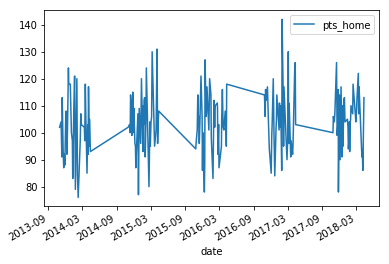

In [51]:
df_atl.plot.line('date', 'pts_home')